# Задание 10

In [4]:
from scipy.integrate import dblquad

## 1. Integral (0.5)

1. Найдите следуюций интеграл (0.25):
<img src="http://www.machinelearning.ru/mimetex/?ifunc(loc,scale)=\frac{1}{2\pi}\sqrt{\frac{1}{2\pi}}\int\limits_{-1}^{1}\int\limits_{-y}^{y}{e^{-0.5(\frac{{x-loc}}{scale})^2}}{e^{-0.5(\frac{{y-loc}}{scale})^2}}{e^{-0.5(\frac{{xy-loc}}{scale})^2}}dxdy">
2. Постройте график функции (0.25): <img src="http://www.machinelearning.ru/mimetex/?ifunc(\eps,n):loc,scale\in[0.001,5],locstep=0.1,scalestep=0.5">

В задании желательно не пользоваться циклами и итераторами (map и тд). За это будут снижены баллы (возможно) ^-^

Пример графика:

<img src="sample.png">

### Решение

In [1]:
import numpy as np

#### Запишите подинтегральную функцию


In [32]:
def func(x, y, loc, scale):
    degree = (x-loc)**2 + (y-loc)**2 + (x*y-loc)**2
    degree /= -2 * scale**2
    return np.exp(degree) / (2*np.pi)**(3/2)

#### Найдите интегральную функцию

In [100]:
def ifunc(loc, scale):
    return dblquad(lambda x, y: func(x, y, loc, scale), -1, 1, lambda x: -x, lambda x: x)[0]

In [101]:
loc = 0.03
scale = 0.1
integrated_func = ifunc(loc, scale)

In [102]:
integrated_func

0.0006314732850851026

#### Получите сетку

In [103]:
def get_grids(loc_step=0.1, loc_low=0.001, loc_high=5, scale_step=0.5, scale_low=0.001, scale_high=5):
    # define loc_grid, scale_grid
    loc_grid = np.arange(loc_low, loc_high, loc_step)
    scale_grid = np.arange(scale_low, scale_high, scale_step)
    loc_grid, scale_grid = np.meshgrid(loc_grid, scale_grid)
#     grid = cartesian([loc_grid, scale_grid])
# #     print(loc_grid.shape, scale_grid.shape, grid.shape)
#     loc_grid, scale_grid = list(zip(*grid))
#     loc_grid = np.array(loc_grid)
#     scale_grid = np.array(scale_grid)
# #     print(loc_grid.shape, scale_grid.shape)
    
    integrated_func = np.vectorize(ifunc)
    ifunc_grid = integrated_func(loc_grid, scale_grid)
    return loc_grid, scale_grid, ifunc_grid

In [104]:
# Здесь (возможно) придется подождать
loc_grid, scale_grid, ifunc_grid = get_grids()

In [105]:
scale_grid.shape

(10, 50)

In [106]:
ifunc_grid.shape

(10, 50)

#### Постройте график

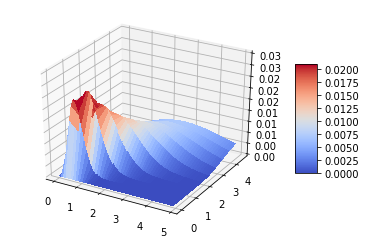

In [107]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(loc_grid, scale_grid, ifunc_grid, cmap=cm.coolwarm,
                       linewidth=1, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 0.03)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.002f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## 2. Linear programming (0.5)

#### Постановка задачи об оптимальном портфеле Марковица

Рассмотрим общую задачу распределения капитала, который участник рынка хочет потратить на приобретение ценных бумаг. Цель инвестора – вложить деньги так, чтобы сохранить свой капитал, а при возможности и нарастить его.

Набор ценных бумаг, находящихся у участника рынка, называется его портфелем. Стоимость портфеля – это суммарная стоимость всех составляющих его бумаг. Если сегодня его стоимость есть Р, а через год она окажется равной Р', то (Р'- Р)/Р естественно назвать доходностью портфеля в процентах годовых. Доходность портфеля – это доходность на единицу его стоимости.

Пусть xi – доля капитала, потраченная на покупку ценных бумаг i-го вида. Весь выделенный капитал принимается за единицу. Пусть di – доходность в процентах годовых бумаг i-го вида в расчете на одну денежную единицу.

Доходность колеблется во времени, так что будем считать ее случайной величиной. Пусть mi, ri – средняя ожидаемая доходность и среднее квадратическое отклонение, называемое риском.

Каждый владелец портфеля ценных бумаг сталкивается с дилеммой: хочется иметь эффективность больше, а риск меньше. Однако, поскольку “нельзя поймать двух зайцев сразу”, необходимо сделать определенный выбор между эффективностью и риском.

#### Оптимальный портфель Марковица максимальной доходности и заданного, (приемлемого) риска:

<img src="markoviz.png">

В задании вам предстоит решить эту задачу линейного программирования.

#### Входные данные

In [132]:
import numpy as np
d = np.array([12.19916667, 13.17116667, 13.98283333, 13.73466667, 13.46983333, 14.84666667])
v = np.array([2.117, 3.546, 4.512, 4.694, 4.154, 3.95, 1.903, 3.882, 4.098, 3.776, 3.202, 2.901,
              5.574, 5.402, 5.522, 3.935, 4.928, 4.63, 2.723, 4.728, 3.067])
r = 0.2

#### Найдите максимум функции доходности и доли и доходности каждой акции

In [137]:
from scipy.optimize import minimize

In [138]:
def con_sum(x):
    return x.sum() - 1

def con_bound(x):
    return np.concatenate((x[x>1], x[x<0])).shape[0]

def con_r(x):
    return x.dot(v.reshape((x.shape[0], x.shape[0]))).dot(x) - r

cons = [{'type':'eq', 'fun': con_sum},
        {'type':'eq', 'fun': con_bound},
        {'type':'eq', 'fun': con_r}]

In [139]:
def min_f(x, d):
    return -x.dot(d)

In [140]:
coefs_m = minimize(min_f, np.ones(d.shape[0])/d.shape[0], args=(d, ), constraints=cons)

ValueError: cannot reshape array of size 21 into shape (6,6)